In [1]:
# reload lib in case of changes
import numpy as np
from torch.utils.data import DataLoader
import torch

In [2]:
path_file = '/Volumes/DataDisk/thesis/data_simulations/3/3.npz'

In [3]:
# Load the data
data = np.load(path_file)

burning_data, winds = data['burning_data'], data['winds']

In [4]:
caorse_data = np.load('/Users/lorenzobenzoni/Documents/university/thesis/repo/data/processed/3/real_coarse/coarse_4/3_coarse_8_adjusted.npz')

coarse_data = caorse_data['burning_data']

In [5]:
# since for each simulation the winds in costant, for each cell and in time, we can take the first one

map_wind = lambda x: x[0, 0]

winds = np.array(list(map(map_wind, winds)))

winds = winds[:, :2]

In [6]:
%load_ext autoreload
%autoreload 2

In [8]:
# remove the first 10 timesteps since are difficult to autoencode

burning_data = burning_data[:, 10:]
coarse_data = coarse_data[:, 10:]

In [9]:
from src.datasets.utils import upscale_map

coarse_burning_data = np.zeros_like(burning_data)
cbd = coarse_data
for i in range(cbd.shape[0]):
    for j in range(cbd.shape[1]):
        upscaled = upscale_map(cbd[i, j], 8)
        coarse_burning_data[i, j] = upscaled

2025-02-06 14:52:56.758 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /Users/lorenzobenzoni/Documents/university/thesis/repo


In [10]:
coarse_data = coarse_burning_data

In [11]:
shape = (200, 200)

In [12]:
# load the paramteres
from src.modeling.models import ConvAutoEncoder

device = torch.device('mps')
model = ConvAutoEncoder(latent_dim=10, shape=shape).to(device)
model.load_state_dict(torch.load('/Users/lorenzobenzoni/Documents/university/thesis/repo/models/dataset_3/ConvAutoEncoder/v1.0.0/training_runs/1/weights.pth', weights_only=True))

<All keys matched successfully>

In [15]:
from src.modeling.models import LitConvAutoEncoder

lit_model = LitConvAutoEncoder(model)

In [16]:
from pytorch_lightning.utilities.model_summary import summarize

summarize(lit_model, max_depth=-1)

   | Name                   | Type            | Params | Mode 
--------------------------------------------------------------------
0  | autoencoder            | ConvAutoEncoder | 648 K  | train
1  | autoencoder.encoder    | Sequential      | 97.6 K | train
2  | autoencoder.encoder.0  | Conv2d          | 160    | train
3  | autoencoder.encoder.1  | BatchNorm2d     | 32     | train
4  | autoencoder.encoder.2  | LeakyReLU       | 0      | train
5  | autoencoder.encoder.3  | Dropout2d       | 0      | train
6  | autoencoder.encoder.4  | Conv2d          | 4.6 K  | train
7  | autoencoder.encoder.5  | BatchNorm2d     | 64     | train
8  | autoencoder.encoder.6  | LeakyReLU       | 0      | train
9  | autoencoder.encoder.7  | Dropout2d       | 0      | train
10 | autoencoder.encoder.8  | Conv2d          | 18.5 K | train
11 | autoencoder.encoder.9  | BatchNorm2d     | 128    | train
12 | autoencoder.encoder.10 | LeakyReLU       | 0      | train
13 | autoencoder.encoder.11 | Dropout2d       | 0

(np.float64(-0.5), np.float64(199.5), np.float64(199.5), np.float64(-0.5))

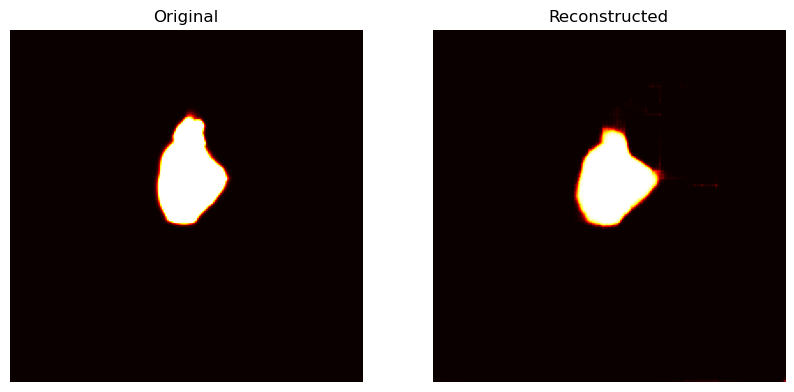

In [17]:
# check if the model is working properly

model.eval()
input = burning_data[48]

# id = np.random.randint(0, len(burning_data))
id = 5
recon_input = model(torch.tensor(input).float().to(device))
recon_input = recon_input.cpu().detach().numpy()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(input[id], cmap='hot')
ax[0].set_title('Original') 
ax[0].axis('off')

ax[1].imshow(recon_input[id], cmap='hot')
ax[1].set_title('Reconstructed')
ax[1].axis('off')

In [31]:
import torch
import torch.nn as nn


class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers, output_dim, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embed_dim = embed_dim

        # Embedding layer
        self.input_embedding = nn.Linear(input_dim, embed_dim)

        self.output_embedding = nn.Linear(output_dim, embed_dim)

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(embed_dim, dropout)

        # Transformer Encoder-Decoder
        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
        )

        # Output layer
        self.output_layer = nn.Linear(embed_dim, output_dim)

    def forward(self, src, tgt):
        """
        Forward pass through the transformer model.
        Args:
            src: Input sequence of shape (batch_size, src_seq_len, input_dim)
            tgt: Target sequence of shape (batch_size, tgt_seq_len, input_dim)
        Returns:
            Output sequence of shape (batch_size, tgt_seq_len, input_dim)
        """
        # Apply input embedding
        src_embed = self.input_embedding(src)
        tgt_embed = self.output_embedding(tgt)

        # Add positional encoding
        src_embed = self.positional_encoding(src_embed)
        tgt_embed = self.positional_encoding(tgt_embed)

        # Pass through the transformer wit generate_square_subsequent_mask
        # attention_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1)).to(src.device)
        # transformer_output = self.transformer(src_embed, tgt_embed, tgt_is_causal=True, tgt_mask=attention_mask)
        transformer_output = self.transformer(src_embed, tgt_embed)

        # Project back to the original input dimension
        output = self.output_layer(transformer_output) + tgt

        return output


class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, dropout=0.1, max_len=64):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute positional encodings
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embed_dim, 2) * -(torch.log(torch.tensor(10000.0)) / embed_dim)
        )
        pe = torch.zeros(max_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

In [32]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import torch
import lightning.pytorch as pl

class LightTransformerMultiFidelityFT(pl.LightningModule):
    def __init__(self, num_layers, d_model, nhead, ff_dim, dropout, lr, weight_decay):
        super(LightTransformerMultiFidelityFT, self).__init__()
        self.save_hyperparameters()
        self.model = TransformerModel(
            input_dim=12,
            embed_dim=d_model,
            num_heads=nhead,
            ff_dim=ff_dim,
            num_layers=num_layers,
            dropout=dropout,
            output_dim=10,
        )
        self.lr = lr
        self.weight_decay = weight_decay
        self.loss_fn = torch.nn.MSELoss()

    def forward(self, src, tgt):
        return self.model(src, tgt)

    def training_step(self, batch, batch_idx):
        (src, _), tgt = batch
        decoder_outputs, decoder_input = tgt
        output = self(src, decoder_input)
        loss = self.loss_fn(output, decoder_outputs)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        (src, _), tgt = batch
        decoder_outputs, decoder_input = tgt
        output = self(src, decoder_input)
        loss = self.loss_fn(output, decoder_outputs)
        self.log("val_loss", loss, prog_bar=True)
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [lr_sched]

In [33]:
best_params = {
    "num_layers": 2,
    "d_model": 64,
    "ff_dim": 256,
    "nhead": 4,
    "dropout": 0.002074056124051083,
    "lr": 0.0020056185255173707,
    "weight_decay": 0.00030650110250357847
}

In [34]:

from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min')

best_model = LightTransformerMultiFidelityFT.load_from_checkpoint('/Users/lorenzobenzoni/Documents/university/thesis/repo/models/dataset_3/TransformerMultiFidelity/v1.0.0/lightning_logs/version_1/checkpoints/epoch=13-step=1498.ckpt', **best_params)



In [35]:
from pytorch_lightning.utilities.model_summary import summarize

summarize(best_model, max_depth=-1)

   | Name                                                       | Type                            | Params  | Mode 
-------------------------------------------------------------------------------------------------------------------------
0  | model                                                      | TransformerModel                | 235 K   | train
1  | model.input_embedding                                      | Linear                          | 832     | train
2  | model.output_embedding                                     | Linear                          | 704     | train
3  | model.positional_encoding                                  | PositionalEncoding              | 0       | train
4  | model.positional_encoding.dropout                          | Dropout                         | 0       | train
5  | model.transformer                                          | Transformer                     | 233 K   | train
6  | model.transformer.encoder                                  | 

In [123]:
from src.datasets.utils import _encode_data

episode_id = 8

burning_data_episode = torch.tensor(burning_data[episode_id]).float()
coarse_data_episode = torch.tensor(coarse_data[episode_id]).float()

burning_data_episode_encoded = _encode_data(burning_data_episode, model, shape=(200, 200)).cpu().detach().numpy()
coarse_data_episode_encoded = _encode_data(coarse_data_episode, model, shape=(200, 200)).cpu().detach().numpy()

In [124]:
from src.datasets.dataset import SequenceDatasetMultiFidelity

burning_data_episode_encoded = burning_data_episode_encoded[np.newaxis]
coarse_data_episode_encoded = coarse_data_episode_encoded[np.newaxis]


dataset = SequenceDatasetMultiFidelity(
    burning_data_episode_encoded,
    coarse_data_episode_encoded,
    winds,
    input_len=10,
    output_len=60,
    hop=0,
    n_samples=390,
    n_simulations=1
)

dataloader = DataLoader(dataset, batch_size=200, shuffle=False)

In [125]:
with torch.no_grad():
    for (X_batch, X_batch_coarse), (y_batch, y_batch_coarse) in dataloader:
        #decoder_outputs = best_model(X_batch_coarse, y_batch_coarse)
        # random input in the decoder
        # shuffle the input on the y_batch_coarse[1]
        # perm = torch.argsort(torch.rand(200, 60), dim=1)
        # y_batch_coarse = y_batch_coarse[torch.arange(y_batch_coarse.size(0))[:, None], perm]
        # y_batch = y_batch[torch.arange(y_batch.size(0))[:, None], perm]
        #
        decoder_outputs = best_model(X_batch, y_batch_coarse)

        #encoder_input = torch.randn_like(X_batch)
        #decoder_outputs = best_model(encoder_input, y_batch_coarse)
        break

In [126]:
best_model = best_model.to('cpu')

In [127]:
starting_point = 0

X_batch = model.decode(X_batch[starting_point, :, :10])
y_batch = model.decode(y_batch[starting_point, :, :10])
decoder_outputs = model.decode(decoder_outputs[starting_point, :, :10])
y_batch_coarse = model.decode(y_batch_coarse[starting_point, :, :10])

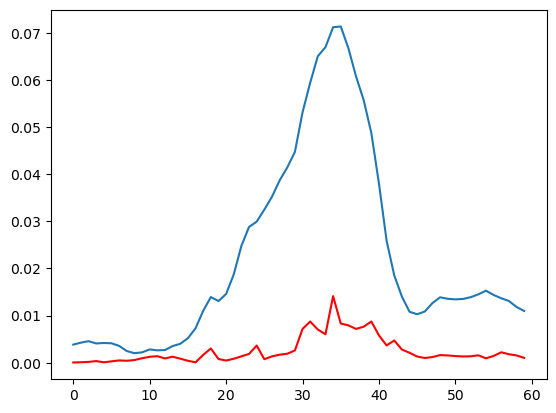

In [112]:
# print the MSE as a function of time
import torch.nn.functional as F
mse = []
mse_coarse = []

for i in range(60):
    mse.append(F.mse_loss(decoder_outputs[i], y_batch[i]).item())
    mse_coarse.append(F.mse_loss(y_batch_coarse[i], y_batch[i]).item())

mse = np.array(mse)
mse_coarse = np.array(mse_coarse)

plt.plot(mse, label='MSE Output - GT', color='red')
plt.plot(mse_coarse, label='MSE Coarse - GT')

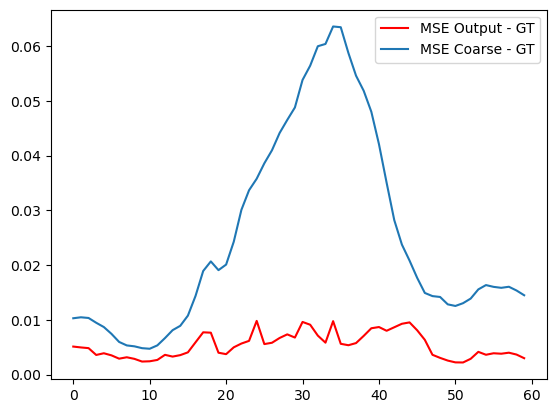

In [113]:
# print the MSE as a function of time
import torch.nn.functional as F
mse = []
mse_coarse = []

for i in range(60):
    mse.append(F.mse_loss(decoder_outputs[i], burning_data_episode[i + 10 + starting_point]).item())
    mse_coarse.append(F.mse_loss(y_batch_coarse[i], burning_data_episode[i + 10 + starting_point]).item())

mse = np.array(mse)
mse_coarse = np.array(mse_coarse)

plt.plot(mse, label='MSE Output - GT', color='red')
plt.plot(mse_coarse, label='MSE Coarse - GT')

plt.legend()

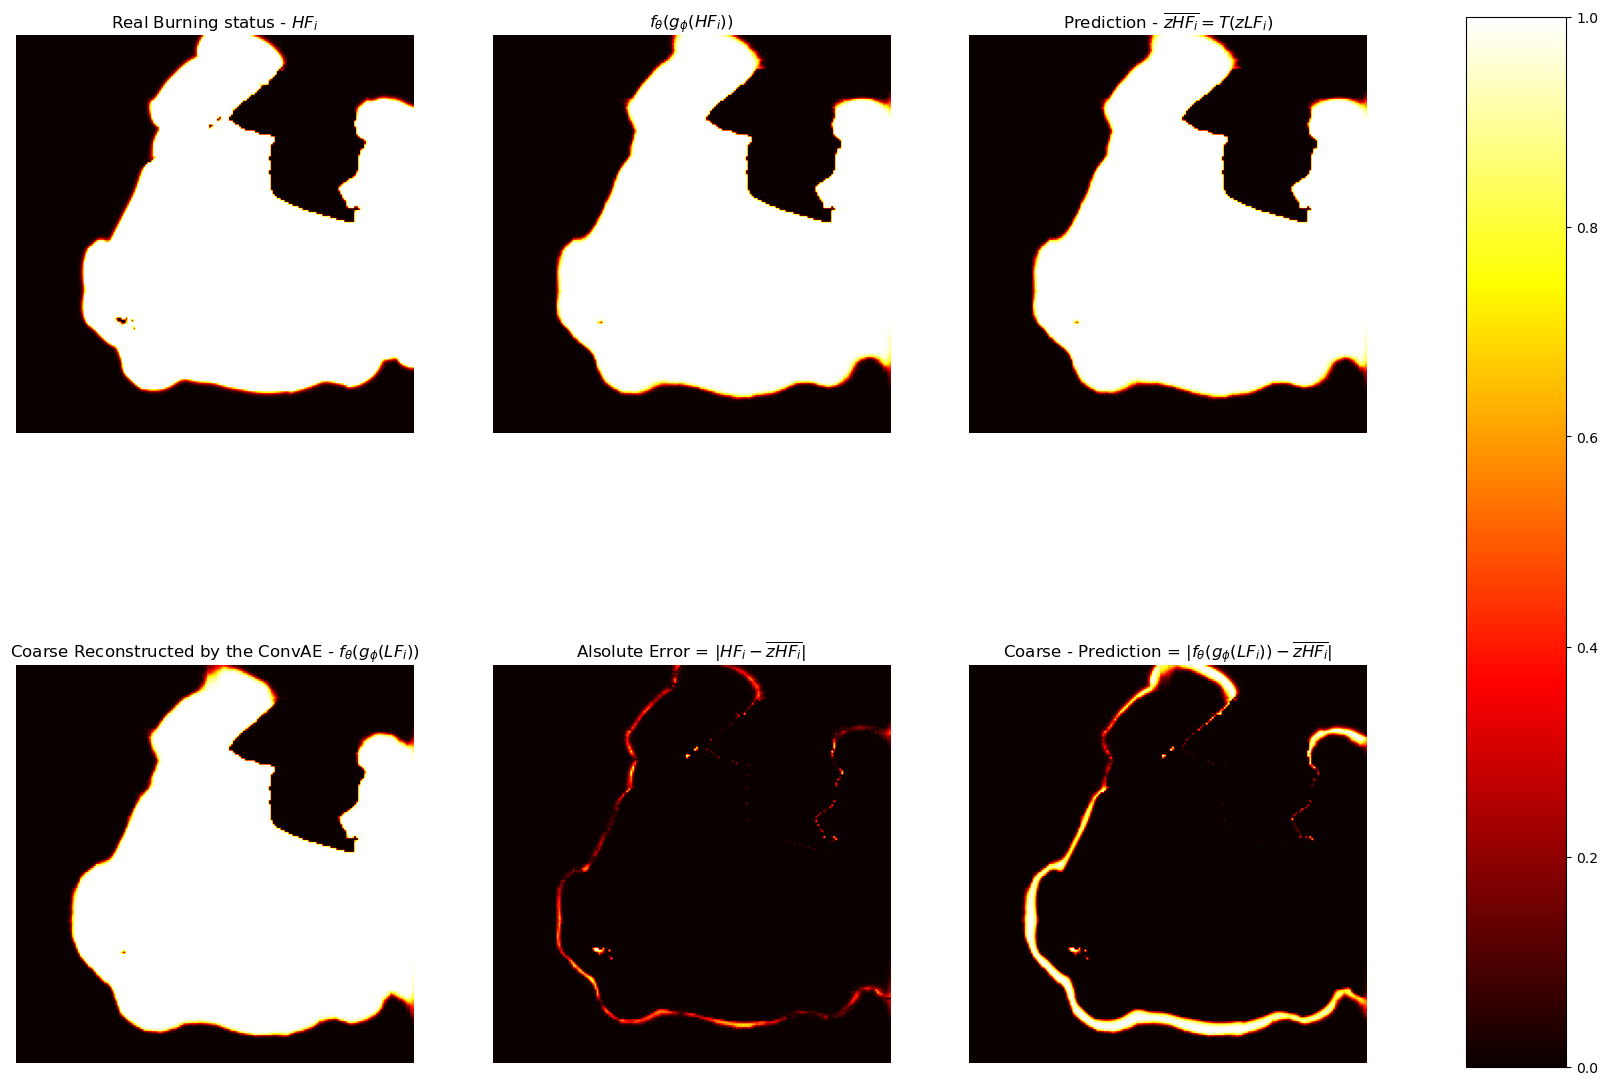

In [128]:
id = 36

fig, axs = plt.subplots(2, 3, figsize=(20, 15))

im = axs[0, 0].imshow(burning_data_episode[id + 10 + starting_point] , cmap='hot',)
axs[0, 0].set_title(r'Real Burning status - $HF_i$')
axs[0, 0].axis('off')

im = axs[0, 1].imshow(y_batch[id].cpu().detach().numpy(), cmap='hot',)
axs[0, 1].set_title(r'$f_\theta(g_\phi(HF_i))$')
axs[0, 1].axis('off')

im = axs[0, 2].imshow(decoder_outputs[id].cpu().detach().numpy(), cmap='hot',)
axs[0, 2].set_title(r'Prediction - $\overline{zHF_i} = T(zLF_i)$')
axs[0, 2].axis('off')

im = axs[1, 0].imshow(y_batch_coarse[id].cpu().detach().numpy(), cmap='hot',)

axs[1, 0].set_title(r'Coarse Reconstructed by the ConvAE - $f_\theta(g_\phi(LF_i))$')

axs[1, 0].axis('off')

im = axs[1, 1].imshow(np.abs(decoder_outputs[id].cpu().detach().numpy() - burning_data_episode[id + 10 + starting_point].numpy()), cmap='hot')

axs[1, 1].set_title(r'Alsolute Error = $|HF_i - \overline{zHF_i} |$')

axs[1, 1].axis('off')

im = axs[1, 2].imshow(np.abs(y_batch_coarse[id].cpu().detach().numpy() - burning_data_episode[id + 10 + starting_point].numpy()), cmap='hot',)

axs[1, 2].set_title(r'Coarse - Prediction = $|f_\theta(g_\phi(LF_i)) - \overline{zHF_i} |$')

axs[1, 2].axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

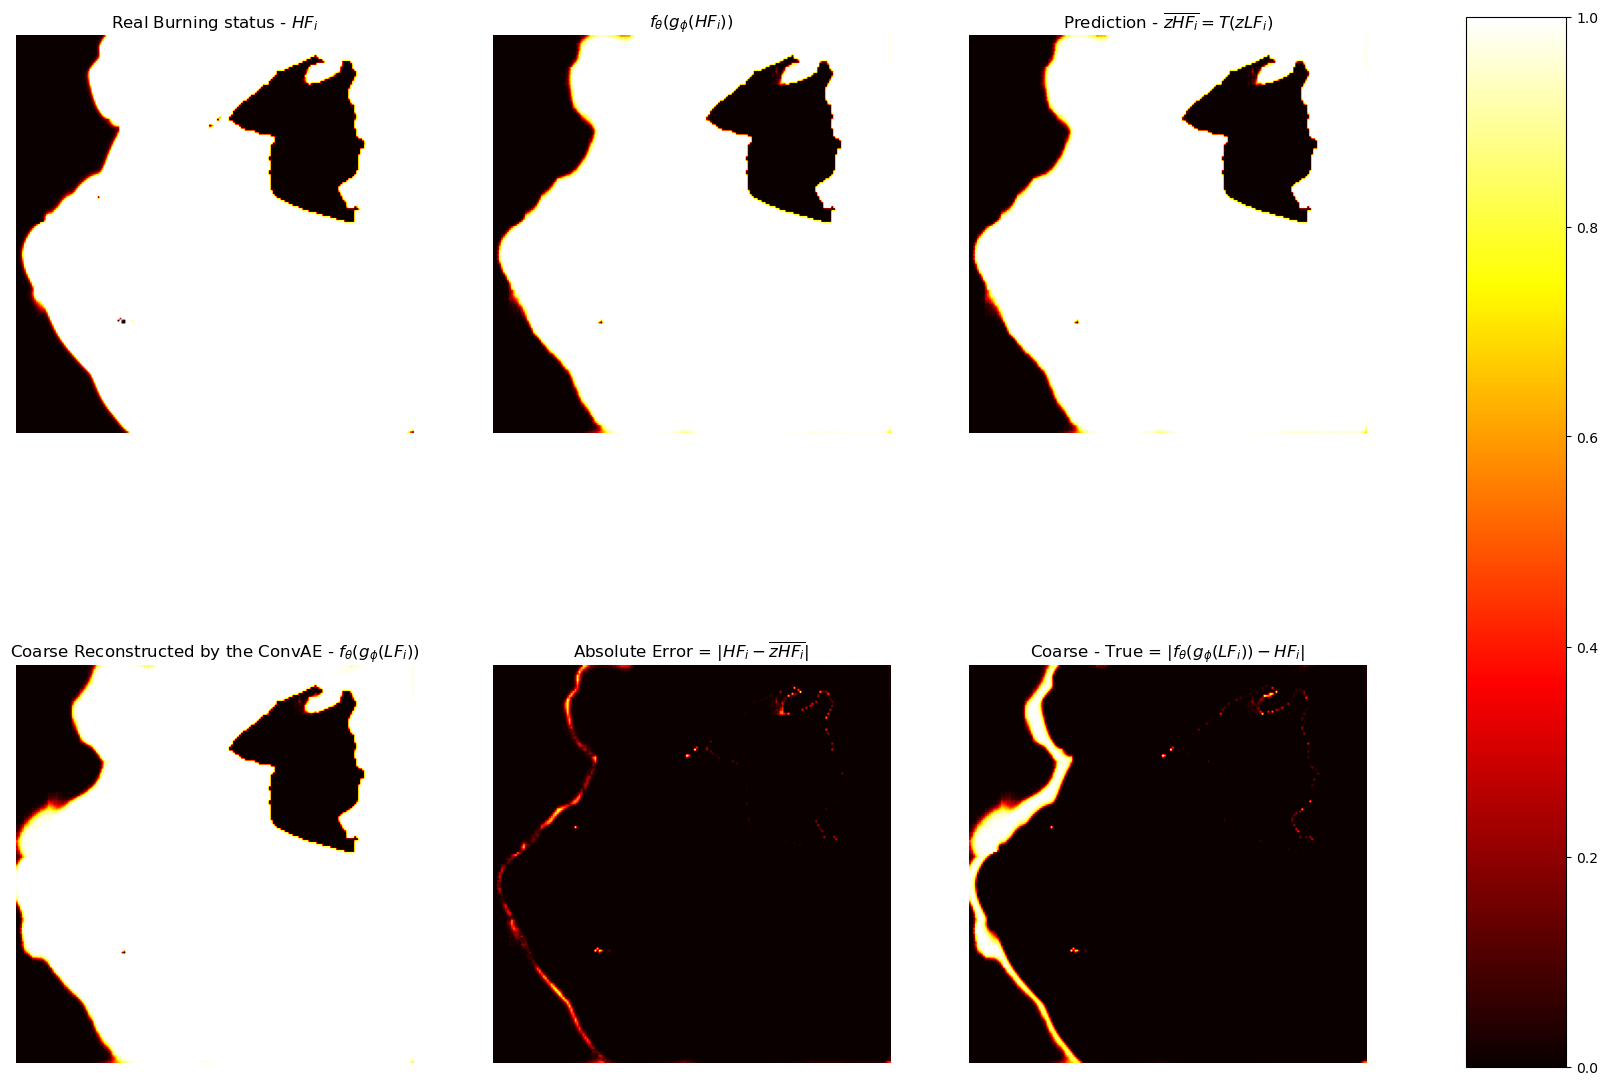

In [129]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Define starting_point if not already defined
starting_point = 0  # Adjust as needed

# Create figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 15))

# Set titles for each subplot
axs[0, 0].set_title(r'Real Burning status - $HF_i$')
axs[0, 1].set_title(r'$f_\theta(g_\phi(HF_i))$')
axs[0, 2].set_title(r'Prediction - $\overline{zHF_i} = T(zLF_i)$')
axs[1, 0].set_title(r'Coarse Reconstructed by the ConvAE - $f_\theta(g_\phi(LF_i))$')
axs[1, 1].set_title(r'Absolute Error = $|HF_i - \overline{zHF_i} |$')
axs[1, 2].set_title(r'Coarse - True = $|f_\theta(g_\phi(LF_i)) - HF_i |$')

# Initialize images with the first frame (id=0)
current_id = 0
true_data = burning_data_episode[current_id + 10 + starting_point].numpy()
y_batch_data = y_batch[current_id].cpu().detach().numpy()
decoder_data = decoder_outputs[current_id].cpu().detach().numpy()
y_coarse_data = y_batch_coarse[current_id].cpu().detach().numpy()

# Create image objects for each subplot
img_real = axs[0, 0].imshow(true_data, cmap='hot', vmin=0, vmax=1)
img_f_hf = axs[0, 1].imshow(y_batch_data, cmap='hot', vmin=0, vmax=1)
img_pred = axs[0, 2].imshow(decoder_data, cmap='hot', vmin=0, vmax=1)
img_coarse = axs[1, 0].imshow(y_coarse_data, cmap='hot', vmin=0, vmax=1)
img_error = axs[1, 1].imshow(np.abs(decoder_data - true_data), cmap='hot', vmin=0, vmax=1)
img_coarse_error = axs[1, 2].imshow(np.abs(y_coarse_data - true_data), cmap='hot', vmin=0, vmax=1)

# Add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img_coarse_error, cax=cbar_ax)

# Turn off axes
for row in axs:
    for ax in row:
        ax.axis('off')

# Initialization function for the animation
def init():
    img_real.set_data(burning_data_episode[0 + 10 + starting_point].numpy())
    img_f_hf.set_data(y_batch[0].cpu().detach().numpy())
    img_pred.set_data(decoder_outputs[0].cpu().detach().numpy())
    img_coarse.set_data(y_batch_coarse[0].cpu().detach().numpy())
    img_error.set_data(np.abs(decoder_outputs[0].cpu().detach().numpy() - burning_data_episode[0 + 10 + starting_point].numpy()))
    img_coarse_error.set_data(np.abs(y_batch_coarse[0].cpu().detach().numpy() - burning_data_episode[0 + 10 + starting_point].numpy()))
    return [img_real, img_f_hf, img_pred, img_coarse, img_error, img_coarse_error]

# Update function for each frame
def update(frame):
    current_id = frame
    true_data = burning_data_episode[current_id + 10 + starting_point].numpy()
    y_batch_data = y_batch[current_id].cpu().detach().numpy()
    decoder_data = decoder_outputs[current_id].cpu().detach().numpy()
    y_coarse_data = y_batch_coarse[current_id].cpu().detach().numpy()

    img_real.set_data(true_data)
    img_f_hf.set_data(y_batch_data)
    img_pred.set_data(decoder_data)
    img_coarse.set_data(y_coarse_data)
    img_error.set_data(np.abs(decoder_data - true_data))
    img_coarse_error.set_data(np.abs(y_coarse_data - true_data))

    return [img_real, img_f_hf, img_pred, img_coarse, img_error, img_coarse_error]

# Create the animation
ani = animation.FuncAnimation(
    fig,
    update,
    frames=60,  # Adjust number of frames as needed
    init_func=init,
    interval=10,
    blit=True
)

# Save the animation
ani.save(f"4.multi_fidelity_simulation_transformer_{episode_id}_coarse_8_adjusted_longer.mp4", writer="ffmpeg", fps=10)

plt.show()